qwen-2.5-0.5B-instruct-sft-lora-countdown-deepseek-5k [0.1328125, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-o3-1k [0.0078125, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-o3-5k [0.0, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-1k [0.010416666666666666, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-seq8k-5k [0.0234375, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-search-1k [0.140625, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-1k [0.03125, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k [0.0078125, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-seq8k-5k [0.234375, 0]
qwen-2.5-0.5B-instruct-sft-lora-countdown-search-seq8k-5k [0.375, 0]
qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-5k [0, 0.2109375]
qwen-2.5-1.5B-instruct-sft-lora-countdown-deepseek-correct-seq8k-1k [0, 0.3125]
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k [0, 0.013020833333333334]
qwen-2.5-1.5B-instruct-sft-lora-countdown-optimal-seq8k-5k [0, 

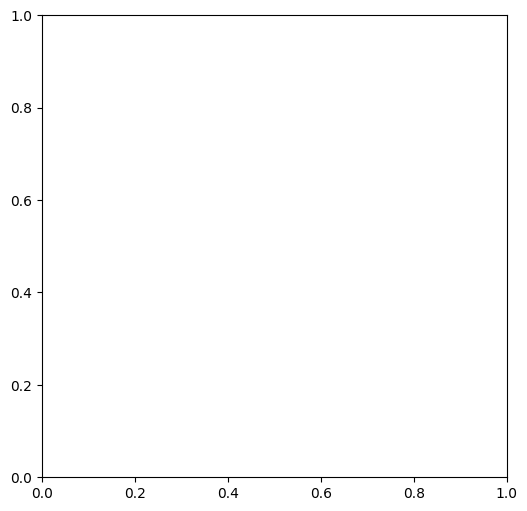

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import os
import re


def extract_parts(string):
    # Try the original pattern for folders with "countdown-"
    pattern1 = re.compile(r'(\d+\.\d+B).*countdown-(.+?)$')
    match = pattern1.search(string)
    
    if match:
        return [match.group(1), match.group(2)]
    
    string = string.lower()
    # Pattern for folders like "Qwen2.5-1.5B-Instruct"
    pattern2 = re.compile(r'qwen\d+\.\d+-(\d+\.\d+B)-instruct', re.IGNORECASE)
    match = pattern2.search(string)
    
    if match:
        return [match.group(1), "base_model"]
    
    # If no pattern matches, return default values
    return ["unknown", "unknown"]

# Dictionary to store data by model and folder
data_by_model = {}
# Store individual run data
run_details = {}
# Dictionary to store sample sizes by folder
folder_sample_sizes = {}

for folder in glob.glob("./qwen*".lower()):
    folder_name = os.path.basename(folder)
    
    for file in glob.glob(f"{folder}/test*.json"):
        with open(file, "r") as f:
            data = json.load(f)
        
        hyperparams = data[0]['hyperparams']
        mean = data[1]['mean']
        model_name = hyperparams['adapter'].split("instruct")[0].split("2.5-")[-1]
        sample_size = hyperparams['num']
        experiment_name = hyperparams.get('experiment_name', os.path.basename(file))
        # print(experiment_name)
        experiment_name = "_".join(extract_parts(experiment_name))
        # Store folder sample size
        folder_sample_sizes[folder_name] = sample_size
        
        run_id = f"{model_name}_{folder_name}_{os.path.basename(file)}"
        run_details[run_id] = {
            "success_rate": mean,
            "model": model_name,
            "folder": folder_name,
            "file": os.path.basename(file),
            "sample_size": sample_size,
            "experiment_name": experiment_name.split(".json")[0]
        }
        
        if model_name not in data_by_model:
            data_by_model[model_name] = {}
        
        data_by_model[model_name][folder_name] = mean

# 1. Overall Comparison Plot
# Get unique model names and folder names
models = sorted(data_by_model.keys())
folder_names = sorted(set(folder for model_data in data_by_model.values() for folder in model_data.keys()))

# Create a figure with 3 subplots (1 row, 3 columns)
fig = plt.figure(figsize=(6, 6))

# 1. Overall Comparison Plot (first subplot)
ax_main = plt.subplot(1, 1, 1)

# Set up the bar chart
x = np.arange(len(models))
width = 0.8 / len(folder_names)  # Width of each bar
# Use a colormap with more distinct colors to avoid similar colors
colors = plt.cm.tab20(np.linspace(0, 1, len(folder_names)))

# Plot bars for each folder
for i, folder in enumerate(folder_names):
    values = [data_by_model[model].get(folder, 0) for model in models]
    print(folder, values)
    


In [58]:
import pandas as pd
methods = {
    "Baseline": "qwen-2.5-x.5B-instruct-baseline",
    "OP": "qwen-2.5-x.5B-instruct-sft-lora-countdown-optimal-seq8k-5k",
    "SoS": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-seq8k-5k", 
    "RSoS": "qwen-2.5-x.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k", 
    "Distill": "qwen-2.5-x.5B-instruct-sft-lora-countdown-deepseek-5k"
}

tasks = {
    "Countdown:": "test_128", 
    "Countdown-3": "countdown_3num_128", 
    "Countdown-5": "countdown_5num_128",
    "KnK": "knk"
}

sizes = ["0.5B", "1.5B"]

def parse_results_from_json(file):
    try:
        with open(file, 'r') as f:
            data = json.load(f)
        print("File:", file)
        # Extract the relevant information from the JSON data   
        if "knk" in file:
            return data["scores"]["2ppl"]
        if "countdown" in file or "test" in file:
            # hyperparams = data[0]['hyperparams']
            return data[1]['mean']    
    except Exception as e:
        print("Error reading file:", file)
        print("Error message:", e)
        return None

# initialize results to store for sizes, method_key, task_key
results = {size: {method_key: {task_key: None for task_key in tasks.keys()} for method_key in methods.keys()} for size in sizes}

for size_val in sizes:
    for method_key, method_val in methods.items():
        for task_key, task_val in tasks.items():
            folder_to_look_for = f"./{method_val}/{task_val}*.json".replace("x.5B", size_val) 
            specific_file = glob.glob(folder_to_look_for)
            if specific_file:
                results[size_val][method_key][task_key] = parse_results_from_json(specific_file[0])
            
# above works, put their filepath in a pandas df
                 
# put results in a pandas df
df = pd.DataFrame.from_dict({(i, j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                           orient='index')
# Tranpose
df = df.transpose()
# make the df float up to 2 decimals
df = df.round(2)
df.to_latex("results.tex", index=True, float_format="%.2f")

File: ./qwen-2.5-0.5B-instruct-baseline/test_128_20250404-180326.json
File: ./qwen-2.5-0.5B-instruct-baseline/countdown_3num_128_20250405-003745.json
File: ./qwen-2.5-0.5B-instruct-baseline/countdown_5num_128_20250405-010314.json
File: ./qwen-2.5-0.5B-instruct-baseline/knk.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-seq8k-5k/test_128_20250401-224033.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-seq8k-5k/countdown_3num_128_20250405-003238.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-optimal-seq8k-5k/countdown_5num_128_20250405-003706.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-search-seq8k-5k/test_128_20250405-120918.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k/test_128_20250404-042128.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-search-react-correct-seq10k-5k/countdown_3num_128_20250405-124251.json
File: ./qwen-2.5-0.5B-instruct-sft-lora-countdown-deepseek-5k/test_128_20250405-12